<center><img src="https://www.mindinventory.com/blog/wp-content/uploads/2019/04/python-development-1200x500.png" width="1000"></center>

## Informacion de la data

El 15 de abril de 1912, durante su viaje inaugural, el RMS Titanic, ampliamente considerado "insumergible", se hundió después de chocar con un iceberg. Desafortunadamente, no había suficientes botes salvavidas para todos a bordo, lo que resultó en la muerte de 1502 de los 2224 pasajeros y la tripulación.

Si bien hubo algún elemento de suerte involucrado en sobrevivir, parece que algunos grupos de personas tenían más probabilidades de sobrevivir que otros.

In [1]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

Definimos las columnas que son categoricas y numericas

In [4]:
numeric_features = ['age', 'fare']
categorical_features = ['embarked', 'sex', 'pclass']

Existen dos Pipeline uno de la libreria SKlearn y otro de Imblearn.

La diferencia de Imblearn es que puede usar las funciones de balanceo de datos

Para que no haiga conflicto le añadimos un nombre que lo diferencie

In [5]:
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.pipeline import Pipeline as skPipeline

Nos piden los siguientes requisitos:

    - Numericas:Imputacion por la media y estandarizacion de los datos
    
    - Categoricas:Imputacion por el mas frecuente y codificar las variables categoricas

Se utiliza una canalización de aprendizaje automático para ayudar a automatizar los flujos de trabajo de aprendizaje automático. Operan al permitir que una secuencia de datos se transforme y correlacione en un modelo que se puede probar y evaluar para lograr un resultado.

In [6]:

numeric_transformer = skPipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_transformer = skPipeline(steps=[
    ('simple_imputer', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))])


**ColumnTransformer**

Permite que diferentes columnas o subconjuntos de columnas de la entrada se transformen por separado y las características generadas por cada transformador se concatenarán para formar un único espacio de características. 

In [7]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
preprocessor                

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'fare']),
                                ('cat',
                                 Pipeline(steps=[('simple_imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['embarked', 'sex', 'pclass'])])

Un ejemplo de como funciona un Pipeline seria este diagrama donde los pasos que sigue son:

    1.Estandarizacion

    2.Realizar PCA
    
    3.Aprendizaje del Algoritmo
    
    4.Realizar la prediccion

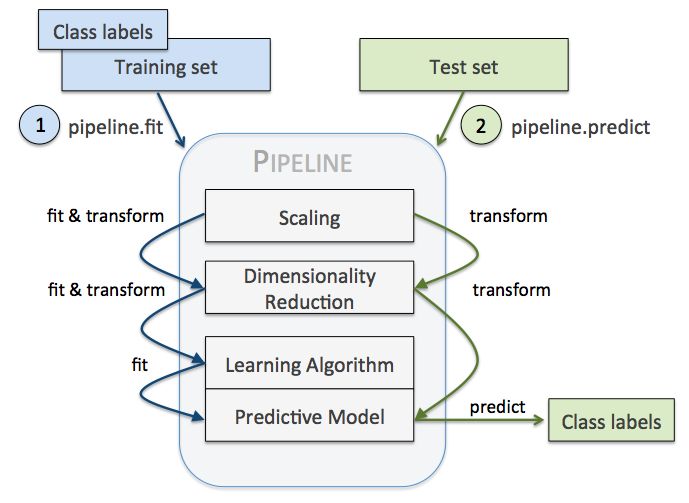

In [8]:
Image(filename='pipeline-diagram.png', width=400) 

Como podremos notar el orden es necesario para indicar al Pipeline que pasos tiene que realizar.

In [9]:

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis

smt = SMOTE(random_state=42)

pca = PCA(n_components=4)
#factor = FactorAnalysis(n_components=4, random_state=101)
clf = skPipeline(steps=[('preprocessor', preprocessor),
                          ("pipeline", imbPipeline([
                              ("smt", smt),
                              ("pca",pca),
                              ("classifier", RandomForestClassifier(n_estimators=100))
                          ]))
                        ])



Se muestra el esquema de nuestro Pipeline

In [10]:
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex'

Dividamos la data de entrenamiento y testeo

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=0)

Entrenamiento del Pipeline

In [13]:
clf.fit(X_train,y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['embarked', 'sex'

- Para ingresar a los Steps del Pipeline usamos "named_steps"

- Para ingresar a los transformers ColumnTransformer seria "named_transformers"

Digamos que queremos ver la varianza explicada del PCA

In [14]:
clf.named_steps.pipeline.named_steps.pca.explained_variance_

array([1.54840478, 0.89000857, 0.46115952, 0.34659193])

Digamos que queremos saber en que orden esta entrenando el OneHotEndocer

In [15]:
clf.named_steps.preprocessor.named_transformers_

{'num': Pipeline(steps=[('simple_imputer', SimpleImputer()),
                 ('scaler', StandardScaler())]),
 'cat': Pipeline(steps=[('simple_imputer', SimpleImputer(strategy='most_frequent')),
                 ('one_hot', OneHotEncoder(handle_unknown='ignore'))]),
 'remainder': 'drop'}

In [16]:
clf.named_steps.preprocessor.named_transformers_.cat.named_steps.one_hot.categories_

[array(['C', 'Q', 'S'], dtype=object),
 array(['female', 'male'], dtype=object),
 array([1.0, 2.0, 3.0], dtype=object)]

In [17]:
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.786


In [18]:
from sklearn.metrics import classification_report#confusion_matrix, , precision_score

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       162
           1       0.73      0.70      0.71       100

    accuracy                           0.79       262
   macro avg       0.77      0.77      0.77       262
weighted avg       0.78      0.79      0.79       262



En caso de que queramos obtener los parametros para realizar hiperparametros podemos obtener los parametros del Pipeline

In [19]:
clf.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'pipeline', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__num', 'preprocessor__cat', 'preprocessor__num__memory', 'preprocessor__num__steps', 'preprocessor__num__verbose', 'preprocessor__num__simple_imputer', 'preprocessor__num__scaler', 'preprocessor__num__simple_imputer__add_indicator', 'preprocessor__num__simple_imputer__copy', 'preprocessor__num__simple_imputer__fill_value', 'preprocessor__num__simple_imputer__missing_values', 'preprocessor__num__simple_imputer__strategy', 'preprocessor__num__simple_imputer__verbose', 'preprocessor__num__scaler__copy', 'preprocessor__num__scaler__with_mean', 'preprocessor__num__scaler__with_std', 'preprocessor__cat__memory', 'preprocessor__cat__steps', 'preprocessor__cat__verbose', 'preprocessor__cat__simple_imputer', 'preprocessor__cat__one_hot', '

Creamos uno nuevo que no este entrenado

In [20]:
clf2 = skPipeline(steps=[('preprocessor', preprocessor),
                          ("pipeline", imbPipeline([
                              ("smt", smt),
                              ("pca",pca),
                              ("classifier", RandomForestClassifier(n_estimators=100))
                          ]))
                        ])

Y lo hacemos pasar por el GridSearchCV

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'pipeline__pca__n_components': [1,2,3,4],
    'pipeline__classifier__max_depth':[2,3,4],
}
search = GridSearchCV(clf2, param_grid, n_jobs=-1)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.777):
{'pipeline__classifier__max_depth': 4, 'pipeline__pca__n_components': 4}
